In [12]:
%pylab inline
import matplotlib
import seaborn
seaborn.set_style("dark")
rcParams['figure.figsize'] = (15, 6)
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import numpy as np
import pysptk
from scipy.io import wavfile
import librosa
import librosa.display
import random
from tqdm import tqdm_notebook

In [3]:
#Storing train files
path = r'spa_data/clips/'
f = open('spa_data/train.tsv', encoding = 'utf8')
data = f.read().split('\n')
traindata = [i.split('\t') for i in data]
f.close()

filenames = [i[3] for i in traindata[1:-1]]
n = len(filenames)
train = []
for i in tqdm_notebook(filenames):
    fs, x = wavfile.read(path + i)
    train.append(x)
    if fs != 48000:
        print(fs)
    

In [6]:
import hickle
pitches = []
for x in tqdm_notebook(train):
    f0 = pysptk.rapt(x.astype(np.float32), fs=fs, hopsize=80, min=60, max=200, otype="f0")
    pitches.append(f0)
hickle.dump(pitches, "features/pitches.hkl",  mode='w')

In [22]:
#Storing mel cepstrums 
frame_length = 1024
hop_length = 80
order = 25
mel_specs = []
for x in tqdm_notebook(train):
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    #apply function along with `time` axis (=1)
    mgc = pysptk.mgcep(frames, order, 0.0, -1.0)
    logH = pysptk.mgc2sp(mgc, 0.0, -1.0, frame_length).real
    mel_specs.append(logH.astype('float32'))

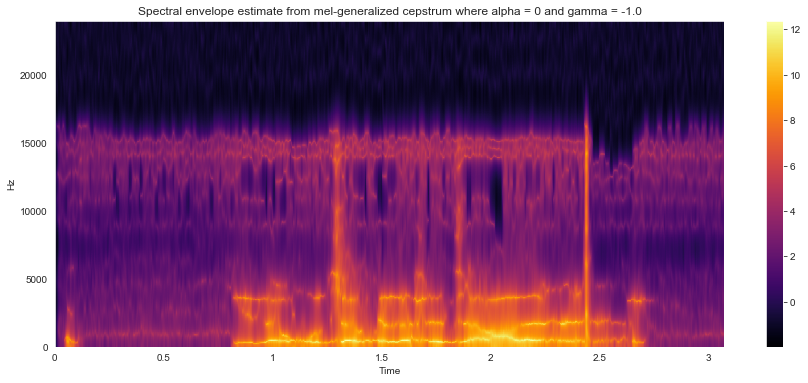

In [47]:
librosa.display.specshow(mel_specs[1].T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum where alpha = 0 and gamma = -1.0");

In [38]:
import hickle
#Saving mel_spectrograms
hickle.dump(mel_specs, 'test.hkl', mode='w')

In [161]:
delta = np.zeros(logH.shape)
for i in range(delta.shape[1]-1):
    delta[:,i] = logH[:,i+1] - logH[:,i]
    
ddelta = np.zeros(delta.shape)
for i in range(delta.shape[1]-1):
    ddelta[:,i] = delta[:,i+1] - delta[:,i]


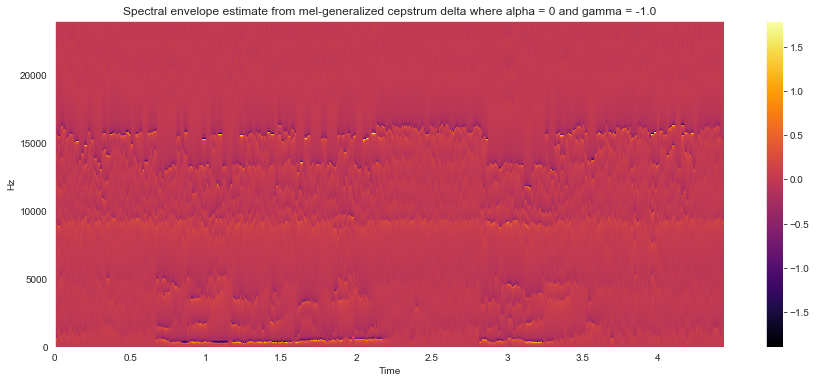

In [162]:
#Plotting deltas
librosa.display.specshow(delta.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum delta where alpha = 0 and gamma = -1.0");    


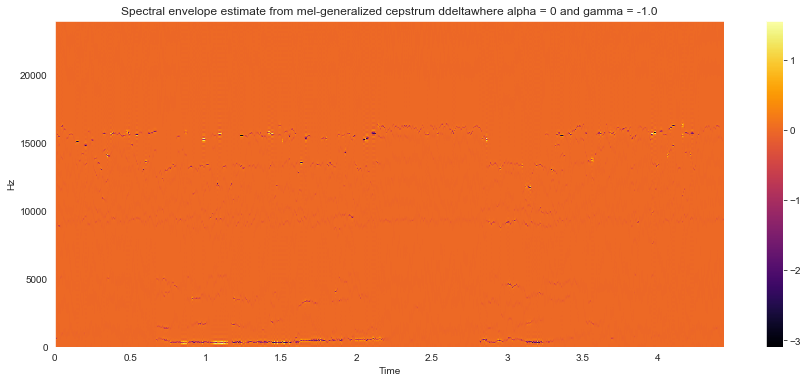

In [163]:
#Plotting double deltas
librosa.display.specshow(ddelta.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum ddeltawhere alpha = 0 and gamma = -1.0");


In [37]:
#Storing mfccs
frame_length = 1024
hop_length = 80
order = 25
mfccs = []
for x in tqdm_notebook(train):
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    #apply function along with `time` axis (=1)
    mgc = pysptk.mgcep(frames, order, 0.0, -1.0)
    logH = pysptk.mgc2sp(mgc, 0.0, -1.0, frame_length).real
    mfcc = librosa.feature.mfcc(y=x, sr=fs, S=logH.T, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
    mfccs.append(mfcc)
    
hickle.dump(mfccs, "features/mfcc.hkl", mode="w")

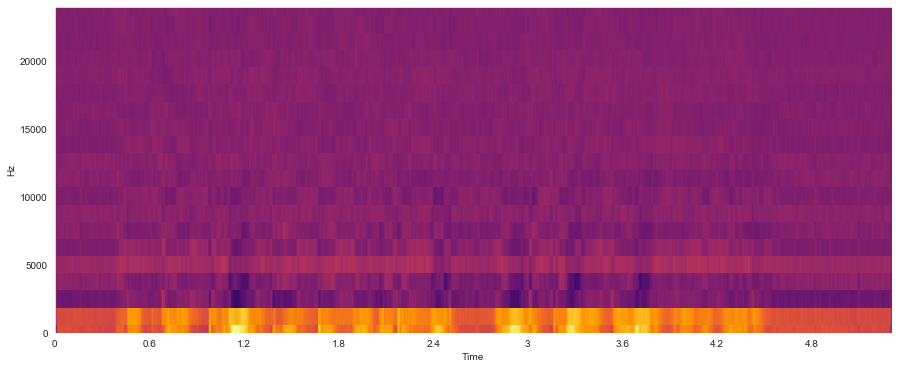

In [36]:
frames = librosa.util.frame(train[1024], frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
frames *= pysptk.blackman(frame_length)
#apply function along with `time` axis (=1)
mgc = pysptk.mgcep(frames, order, 0.0, -1.0)
logH = pysptk.mgc2sp(mgc, 0.0, -1.0, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')
mfcc = librosa.feature.mfcc(y=train[1024], sr=fs, S=logH.T, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
librosa.display.specshow(mfcc, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')


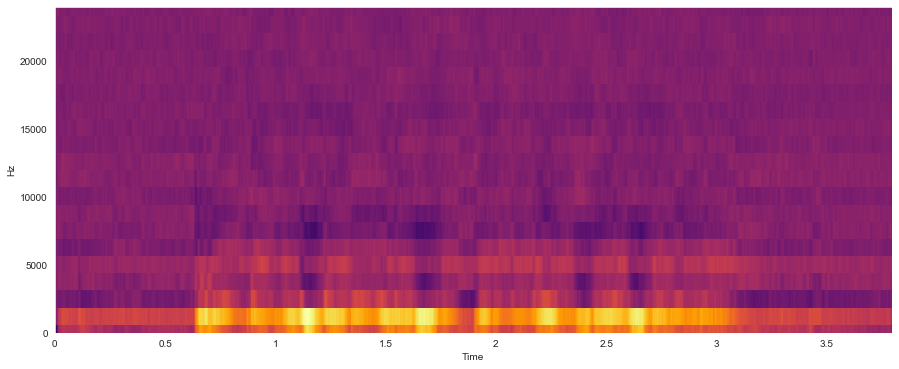

In [43]:
librosa.display.specshow(mfccs[-12], sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')

In [47]:
mfccs[1024].shape

(20, 3185)

In [50]:
#Storing deltas MFCC
deltas = []
for x in tqdm_notebook(mfccs):
    delta = np.zeros(x.shape)
    for i in range(x.shape[1]-1):
        delta[:,i] = x[:,i+1] - x[:,i]
    deltas.append(delta.astype('float32'))
    
hickle.dump(deltas, "features/deltas.hkl", mode="w")

In [62]:
#Storing deltas MFCC
#ddeltas = []
#for x in tqdm_notebook(mfccs):
#    delta = np.zeros(x.shape)
#    for i in range(x.shape[1]-1):
#        delta[:,i] = x[:,i+1] - x[:,i]
#    ddelta = np.zeros(delta.shape)
#    for i in range(delta.shape[1]-1):
#        ddelta[:,i] = delta[:,i+1] - delta[:,i]
#    ddeltas.append(ddelta)
hickle.dump(ddeltas, "features/ddeltas.hkl", mode="w")

In [51]:
del(deltas)

In [77]:
#windowing
x = random.randint(2432)
print(x)
frames = librosa.util.frame(train[x], frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
frames *= pysptk.blackman(frame_length)
#mel-cepstrum
mgc = pysptk.mgcep(frames, order, 0.0, -1.0)
logH = pysptk.mgc2sp(mgc, 0.0, -1.0, frame_length).real
#mfcc
mfcc = librosa.feature.mfcc(y=train[1024], sr=fs, S=logH.T, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
#pitch
f0 = pysptk.rapt(train[x].astype(np.float32), fs=fs, hopsize=80, min=60, max=200, otype="f0")

2103


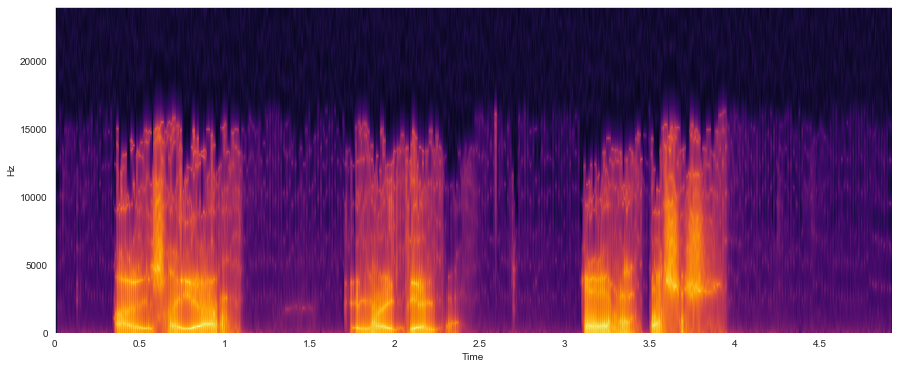

In [78]:
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')

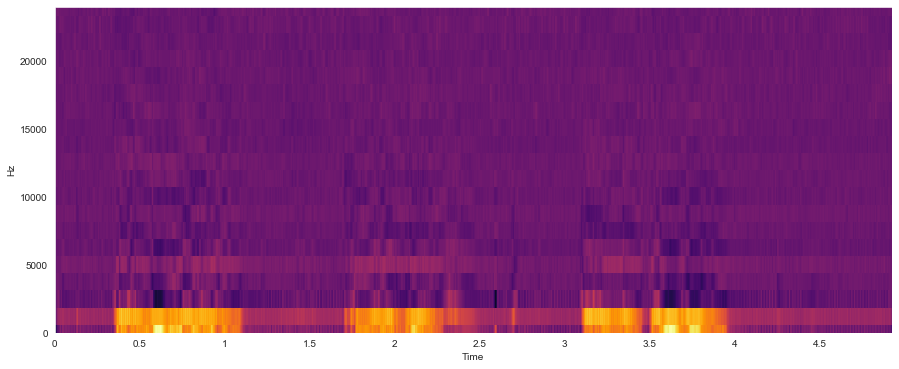

In [79]:
librosa.display.specshow(mfcc, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')

In [80]:
data_dict = {'mfcc':mfcc, 'melc':logH, 'pitch':f0}
hickle.dump(data_dict, "testData2.hkl", mode = 'w')

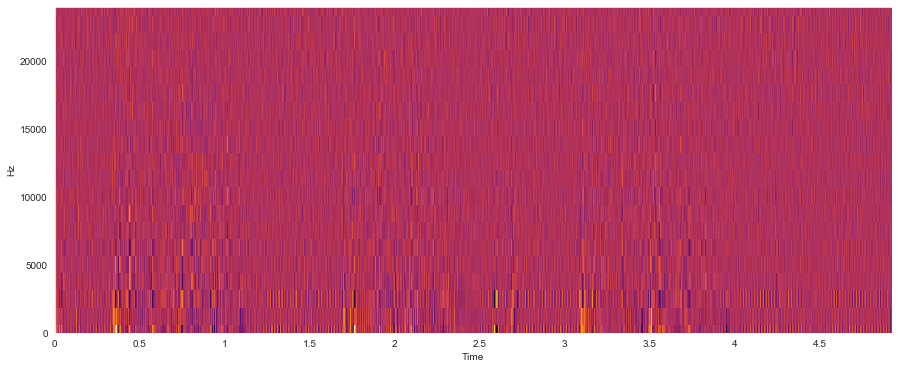

In [81]:
delta = np.zeros(mfcc.shape)
for i in range(mfcc.shape[1]-1):
    delta[:,i] = mfcc[:,i+1] - mfcc[:,i]
librosa.display.specshow(delta, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')

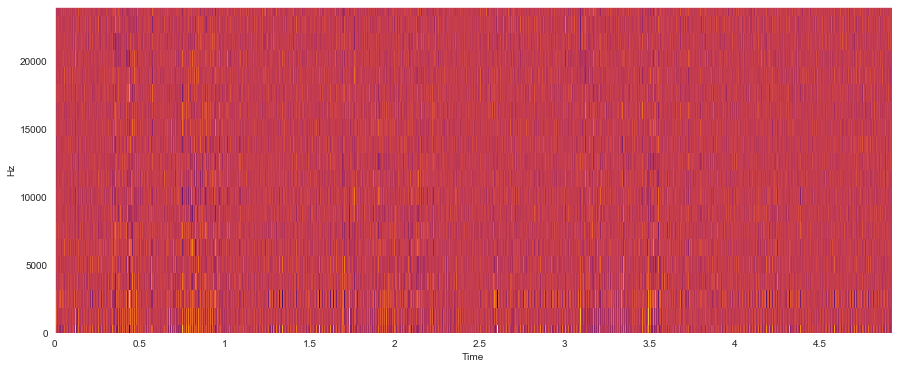

In [82]:
ddelta = np.zeros(delta.shape)
for i in range(delta.shape[1]-1):
    ddelta[:,i] = delta[:,i+1] - delta[:,i]
librosa.display.specshow(ddelta, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear", cmap='inferno')